<h1 style="text-align: center;">Predicting Potential Credit Risks</h1>
<h3 style="text-align: center;">Spring 2024 Data Science Project</h3>
<p style="text-align: center;">Collaborators: Keenan Powell and Anirudh Satheesh</p>
<hr></hr>


<h2 style="text-align: center;">Introduction</h2>
The purpose of this project is to understand and predict which people can be considered as good and bad credit risks. Essentially, a good credit risk means that this person has a low likelihood of defaulting on any potential loans, or that they will not pay the entire loan. This is an important problem because bad credit risks can induce significant financial stress on banks to make up for the money loaned, often by raising the interest rates on other loans to compensate. For example, the Federal Reserve reports that 1.43% of Americans still default on their loans, and while this number is on the decline, insightful data analytics can further help banks avoid bad potential credit risks (FEDR, 2023).

To deal with classifying bad credit risks, we gather several features about each individual in our dataset, such as their employment status, duration with the bank, and credit history, and ask how they correlate with credit risk. For example, we ask does the employment status of the individual have a significant effect on being a credit risk? Does a lower credit amount correspond with a good or bad credit risk? Asking such questions allows us to gain valuble insights on such potential risks, and can allow banks to better allocate their resources for everyone.

Our project is split into 5 stages:
1. Data Collection
2. Data Preprocessing
3. Machine Learning Analysis / Hypothesis Testing
4. Visualizations
5. Insights / Conclusions
<hr></hr>

<h2 style="text-align: center;">Data Collection</h2>
For this project, we use several libraries to aid our data analysis, the main ones being pandas for storing and processing the data and openml, an online platform that helps researchers and data analysts to find and curate datasets and machine learning models.

We list the functionalities of each of the imports we use below:

<b>openml</b>: Used to download the dataset and additional important metadata, such as the type of each feature.

<b>pandas</b>: Used to manipulate / analyze the dataset by converting to dataframe, also used in hypothesis testing.

<b>numpy</b>: Used for helpful math functions and handling large array sizes.

<b>matplotlib</b>: Used to create plots to help analyze and demonstrate aspects about the dataset.

<b>sklearn</b>: Used to for general data preprocessing, such as developing encodings and performing transformations, and machine learning analysis.

<b>scipy</b>: Used for hypothesis testing.

<b>torch</b>: Used for initializing and training the MLP (Multi-Layer Perceptron).

<b>seaborn</b>: Used for data visualization.

In [1]:
import openml
import pandas as pd
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, roc_curve, auc
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import ttest_ind, chi2_contingency
import seaborn as sns

The dataset used in this project is the [credit-g dataset](https://www.openml.org/search?type=task&sort=runs&id=31), which is a binary classification dataset that has 1000 datapoints and 21 features, which includes an individual's checking account status, saving account status, duration with the bank, etc.

In [2]:
# get credit-g dataset with ID 31
dataset = openml.datasets.get_dataset(31)

# extract input, targets, and categorical indicator
df, target, categorical_indicator, _ = dataset.get_data(target=dataset.default_target_attribute)
df.head()

C:\Users\nuggy\AppData\Local\Temp\ipykernel_14416\3980705183.py:2: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  dataset = openml.datasets.get_dataset(31)


,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
0,<0,6,critical/other existing credit,radio/tv,1169.0,no known savings,>=7,4,male single,none,4,real estate,67,none,own,2,skilled,1,yes,yes
1,0<=X<200,48,existing paid,radio/tv,5951.0,<100,1<=X<4,2,female div/dep/mar,none,2,real estate,22,none,own,1,skilled,1,none,yes
2,no checking,12,critical/other existing credit,education,2096.0,<100,4<=X<7,2,male single,none,3,real estate,49,none,own,1,unskilled resident,2,none,yes
3,<0,42,existing paid,furniture/equipment,7882.0,<100,4<=X<7,2,male single,guarantor,4,life insurance,45,none,for free,1,skilled,2,none,yes
4,<0,24,delayed previously,new car,4870.0,<100,1<=X<4,3,male single,none,4,no known property,53,none,for free,2,skilled,2,none,yes


<hr></hr>
<h2 style="text-align: center;">Data Processing</h2>

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   checking_status         1000 non-null   category
 1   duration                1000 non-null   uint8   
 2   credit_history          1000 non-null   category
 3   purpose                 1000 non-null   category
 4   credit_amount           1000 non-null   float64 
 5   savings_status          1000 non-null   category
 6   employment              1000 non-null   category
 7   installment_commitment  1000 non-null   uint8   
 8   personal_status         1000 non-null   category
 9   other_parties           1000 non-null   category
 10  residence_since         1000 non-null   uint8   
 11  property_magnitude      1000 non-null   category
 12  age                     1000 non-null   uint8   
 13  other_payment_plans     1000 non-null   category
 14  housing                 1

In [4]:
# Seperate the columns of the dataset into categorical and continuous subsets.
categorical_features = [i for i in categorical_indicator*df.columns if i != '']
categorical_features += ['installment_commitment', 'residence_since', 'existing_credits', 'num_dependents']
print(f"Categorical features:")
for index, i in enumerate(categorical_features):
    print(f"{index+1}) {i}")

Categorical features:
1) checking_status
2) credit_history
3) purpose
4) savings_status
5) employment
6) personal_status
7) other_parties
8) property_magnitude
9) other_payment_plans
10) housing
11) job
12) own_telephone
13) foreign_worker
14) installment_commitment
15) residence_since
16) existing_credits
17) num_dependents


In [5]:
continuous_features = [i for i in df.columns if i not in categorical_features]
print(f"Continuous features:")
for index, i in enumerate(continuous_features):
    print(f"{index+1}) {i}")

Continuous features:
1) duration
2) credit_amount
3) age


<b>Generate Encodings for Categorical Data</b>

In [6]:
# LabelEncoder converts "target" from an array of "good" and "bad" to an array of 1 and 0 
# so it can more easily be analyzed and compared to other variables. 
target = LabelEncoder().fit_transform(target)
df['class'] = target

In [7]:
feature_maps = {
    'checking_status': {'no checking': 0, '<0': -1, '0<=X<200': 1, '>=200': 2},
    'credit_history': {'no credits/all paid': 2, 'all paid': 1, 'existing paid': 0, 'critical/other existing credit': -1, 'delayed previously': -2},
    'savings_status': {'no known savings': 0, '<100': -1, '100<=X<500': 1, '500<=X<1000': 2, '>=1000': 3},
    'employment': {'unemployed': -1, '<1': 0, '1<=X<4': 1, '4<=X<7': 2, '>=7': 3},
    'job': {'unemp/unskilled non res': 0, 'high qualif/self emp/mgmt': 1, 'unskilled resident': 2, 'skilled': 3},
}
for col in feature_maps:
    df[col] = df[col].map(feature_maps[col]).astype('int')

In [8]:
other_categorical_features = list(set(categorical_features) - set(feature_maps.keys()))
for i in other_categorical_features:
    df[i] = OrdinalEncoder().fit_transform(df[i].values.reshape(-1, 1)).astype('int')

<b>Transform Continuous Features</b>

Unlike the previous categorical features, transforming the continuous features depends on how the features are distributed over the dataset.

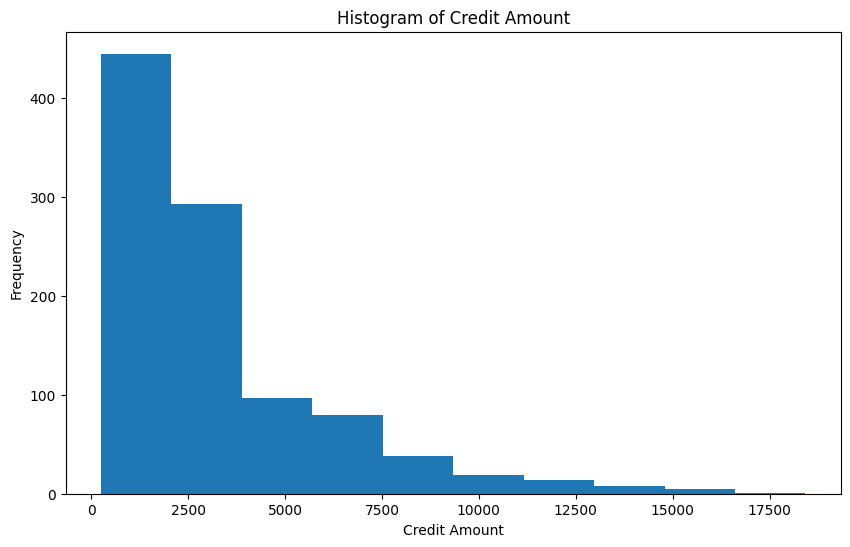

In [9]:
# plot credit amount in histogram
plt.figure(figsize=(10,6))
hist = plt.hist(df['credit_amount'], bins=10)
plt.title('Histogram of Credit Amount')
plt.xlabel('Credit Amount')
plt.ylabel('Frequency')
plt.show()

This distribution is very right skewed, so we should apply a log transform.

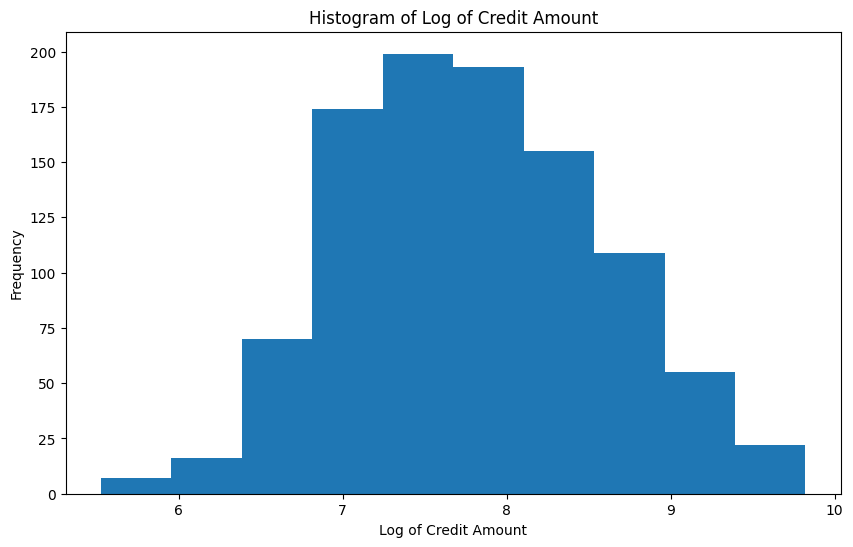

In [10]:
# apply log transform on credit amount and plot the log histogram
df['credit_amount'] = np.log1p(df['credit_amount'])
plt.figure(figsize=(10,6))
hist = plt.hist(df['credit_amount'], bins=10)
plt.title('Histogram of Log of Credit Amount')
plt.xlabel('Log of Credit Amount')
plt.ylabel('Frequency')
plt.show()

This is very similar to a normal distribution, which is what we want. We can perform a similar process for age and duration.

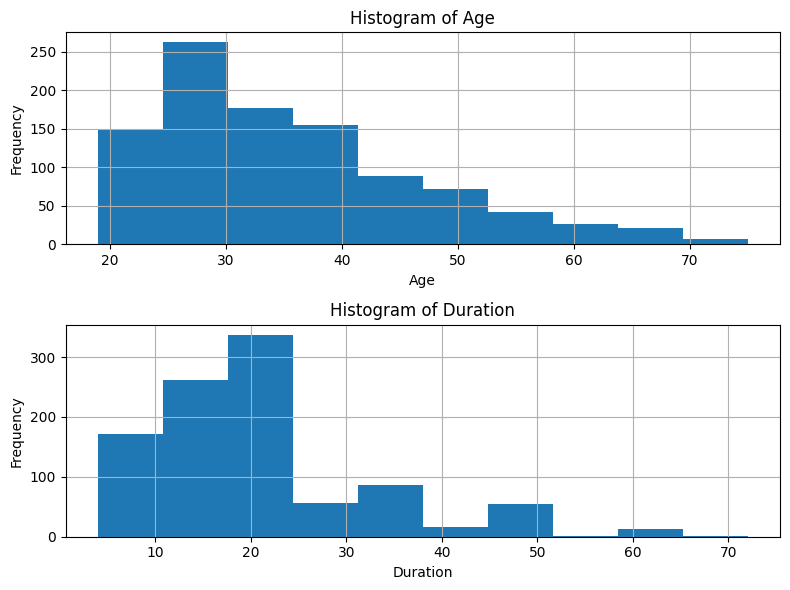

In [11]:
# plot age and duration in seperate histograms next to each other
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))
df['age'].hist(ax=axes[0])
axes[0].set_title('Histogram of Age')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Frequency')
df['duration'].hist(ax=axes[1])
axes[1].set_title('Histogram of Duration')
axes[1].set_xlabel('Duration')
axes[1].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

From the plots, we can see that the distributions of both age and duration are similar to the credit amount, they are both right skewed, so we can use log transforms again to transform these distributions closer to normal distributions.

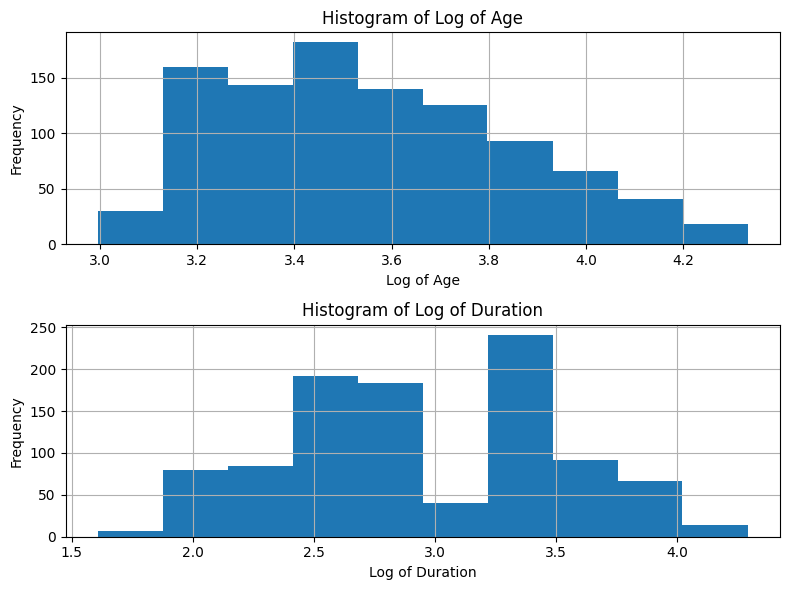

In [12]:
# apply log transform on duration and age and plot the log histograms
df['duration'] = np.log1p(df['duration'])
df['age'] = np.log1p(df['age'])
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))
df['age'].hist(ax=axes[0])
axes[0].set_title('Histogram of Log of Age')
axes[0].set_xlabel('Log of Age')
axes[0].set_ylabel('Frequency')
df['duration'].hist(ax=axes[1])
axes[1].set_title('Histogram of Log of Duration')
axes[1].set_xlabel('Log of Duration')
axes[1].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

<hr></hr>
<h2 style="text-align: center;">Hypothesis Testing and Exploratory Data Analysis</h2>

### Hypothesis Test #1: Does the type of job have a significant effect on the type of credit risk?

H<sub>0</sub>: The type of job has no significant effect on the type of credit risk.

H<sub>a</sub>: The type of job has a significant effect on the type of credit risk.

In [13]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(df['job'], df['class']))
print(f"p-value: {p}")

p-value: 0.5965815918843433


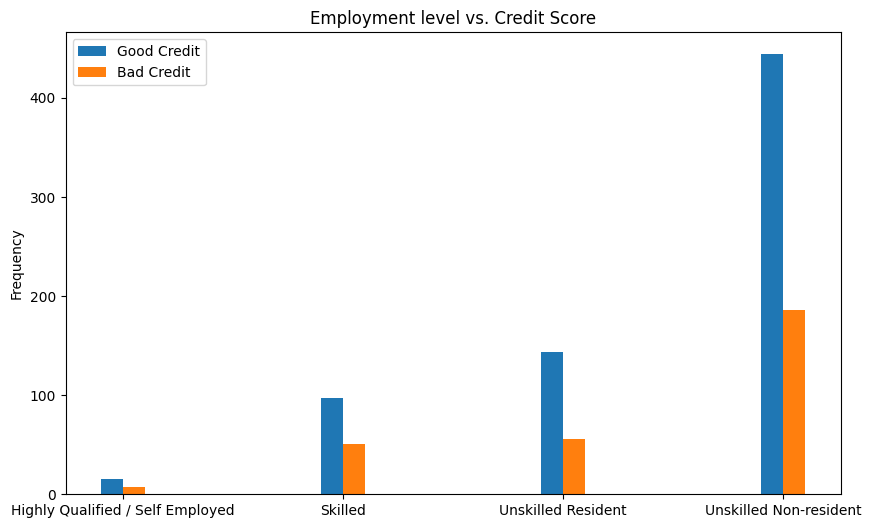

In [14]:
blue_bar = list(df[df['class'] == 1].groupby('job').size())
orange_bar = list(df[df['class'] == 0].groupby('job').size())
fig, ax = plt.subplots(figsize=(10, 6))
ind = np.arange(4)
width = 0.1       
plt.bar(ind, blue_bar , 0.1, label='Good Credit')
plt.bar(ind + 0.1, orange_bar, width, label='Bad Credit')
plt.xticks(ind + 0.05, ['Highly Qualified / Self Employed', 'Skilled', 'Unskilled Resident', 'Unskilled Non-resident'])
plt.ylabel("Frequency")
plt.title("Employment level vs. Credit Score")
plt.legend(loc='best')
plt.show()

### Conclusion
Since the p-value of 0.597 is greater than the alpha threshold of 0.05, we fail to reject the null hypothesis that the type of job has no significant effect on the type of credit risk.

### Hypothesis Test #2: Is the average credit amount lower for good credit risks vs bad credit risks?

Let $\sigma$<sub>g</sub> be the mean credit amount for those who are classified as a good credit risk and let $\sigma$<sub>b</sub> be the mean credit amount for those who are classified as a bad credit risk.

H<sub>0</sub>: $\sigma$<sub>g</sub> = $\sigma$<sub>b</sub>

H<sub>a</sub>: $\sigma$<sub>g</sub> < $\sigma$<sub>b</sub>

In [15]:
# Find credit amount for good and bad risks (perform exponential to reverse log transform before)
good_credit_amount = np.exp(df[df['class'] == 1]['credit_amount'])
bad_credit_amount = np.exp(df[df['class'] == 0]['credit_amount'])
t_statistic, p_value = ttest_ind(good_credit_amount, bad_credit_amount, alternative='less')
p_value


4.398786186764447e-07

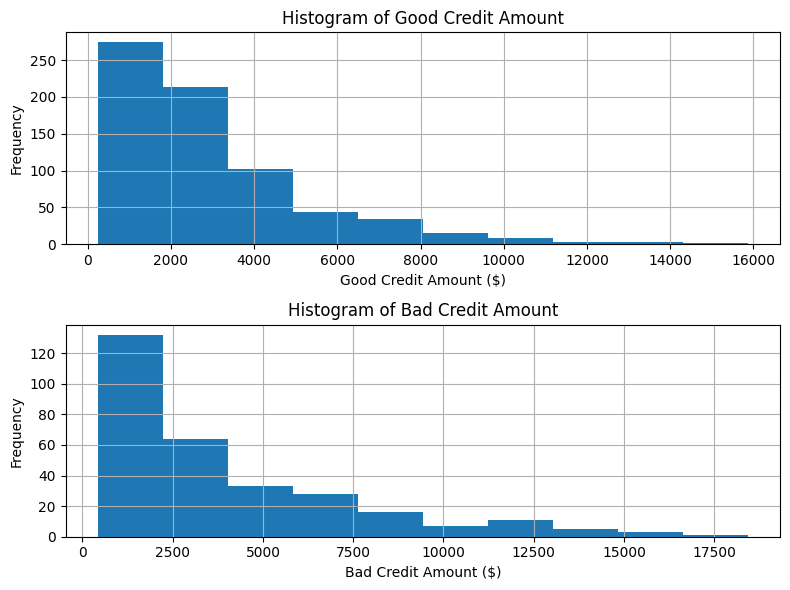

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))
good_credit_amount.hist(ax=axes[0])
axes[0].set_title('Histogram of Good Credit Amount')
axes[0].set_xlabel('Good Credit Amount ($)')
axes[0].set_ylabel('Frequency')
bad_credit_amount.hist(ax=axes[1])
axes[1].set_title('Histogram of Bad Credit Amount')
axes[1].set_xlabel('Bad Credit Amount ($)')
axes[1].set_ylabel('Frequency')
plt.tight_layout()
plt.show()


### Conclusion
Since the p-value of 4.398e-07 is less than the alpha threshold of 0.05, we have sufficient evidence to reject the null hypothesis that the mean credit amount is the same between those that are good credit risks and bad credit risks.

### Hypothesis Test #3: Is the average duration lower for good credit risks vs bad credit risks?

Let $\sigma$<sub>g</sub> be the mean duration for those who are classified as a good credit risk and let $\sigma$<sub>b</sub> be the mean duration for those who are classified as a bad credit risk.

H<sub>0</sub>: $\sigma$<sub>g</sub> = $\sigma$<sub>b</sub>

H<sub>a</sub>: $\sigma$<sub>g</sub> < $\sigma$<sub>b</sub>

In [17]:
good_duration = np.exp(df[df['class'] == 1]['duration'])
bad_duration = np.exp(df[df['class'] == 0]['duration'])
t_statistic, p_value = ttest_ind(good_duration, bad_duration, alternative='less')
print(f"p-value: {p_value}")

p-value: 3.132196862278386e-12


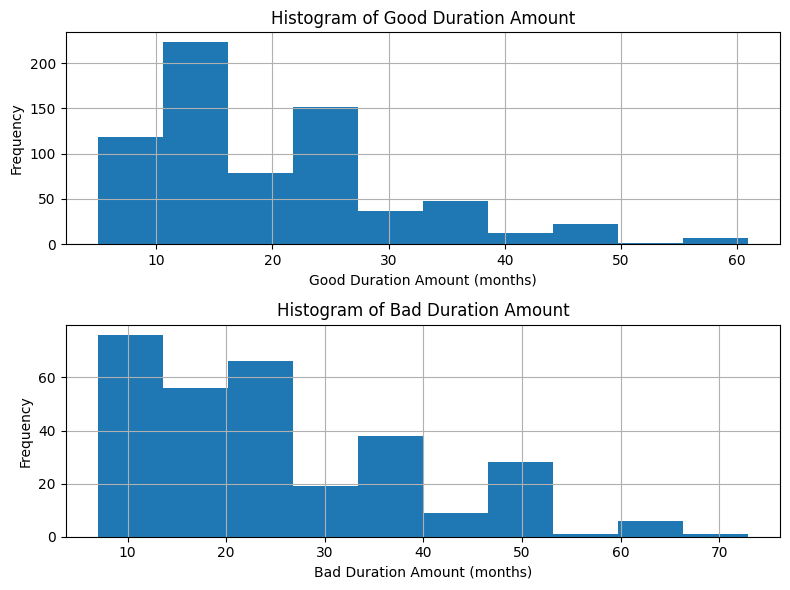

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))
good_duration.hist(ax=axes[0])
axes[0].set_title('Histogram of Good Duration Amount')
axes[0].set_xlabel('Good Duration Amount (months)')
axes[0].set_ylabel('Frequency')
bad_duration.hist(ax=axes[1])
axes[1].set_title('Histogram of Bad Duration Amount')
axes[1].set_xlabel('Bad Duration Amount (months)')
axes[1].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

### Conclusion
Since the p-value of 3.244e-12 is less than the alpha threshold of 0.05, we have sufficient evidence to reject the null hypothesis that the mean duration is the same between those that are good credit risks and bad credit risks.

### Further Data Analysis: Correlation Matrix

<Axes: >

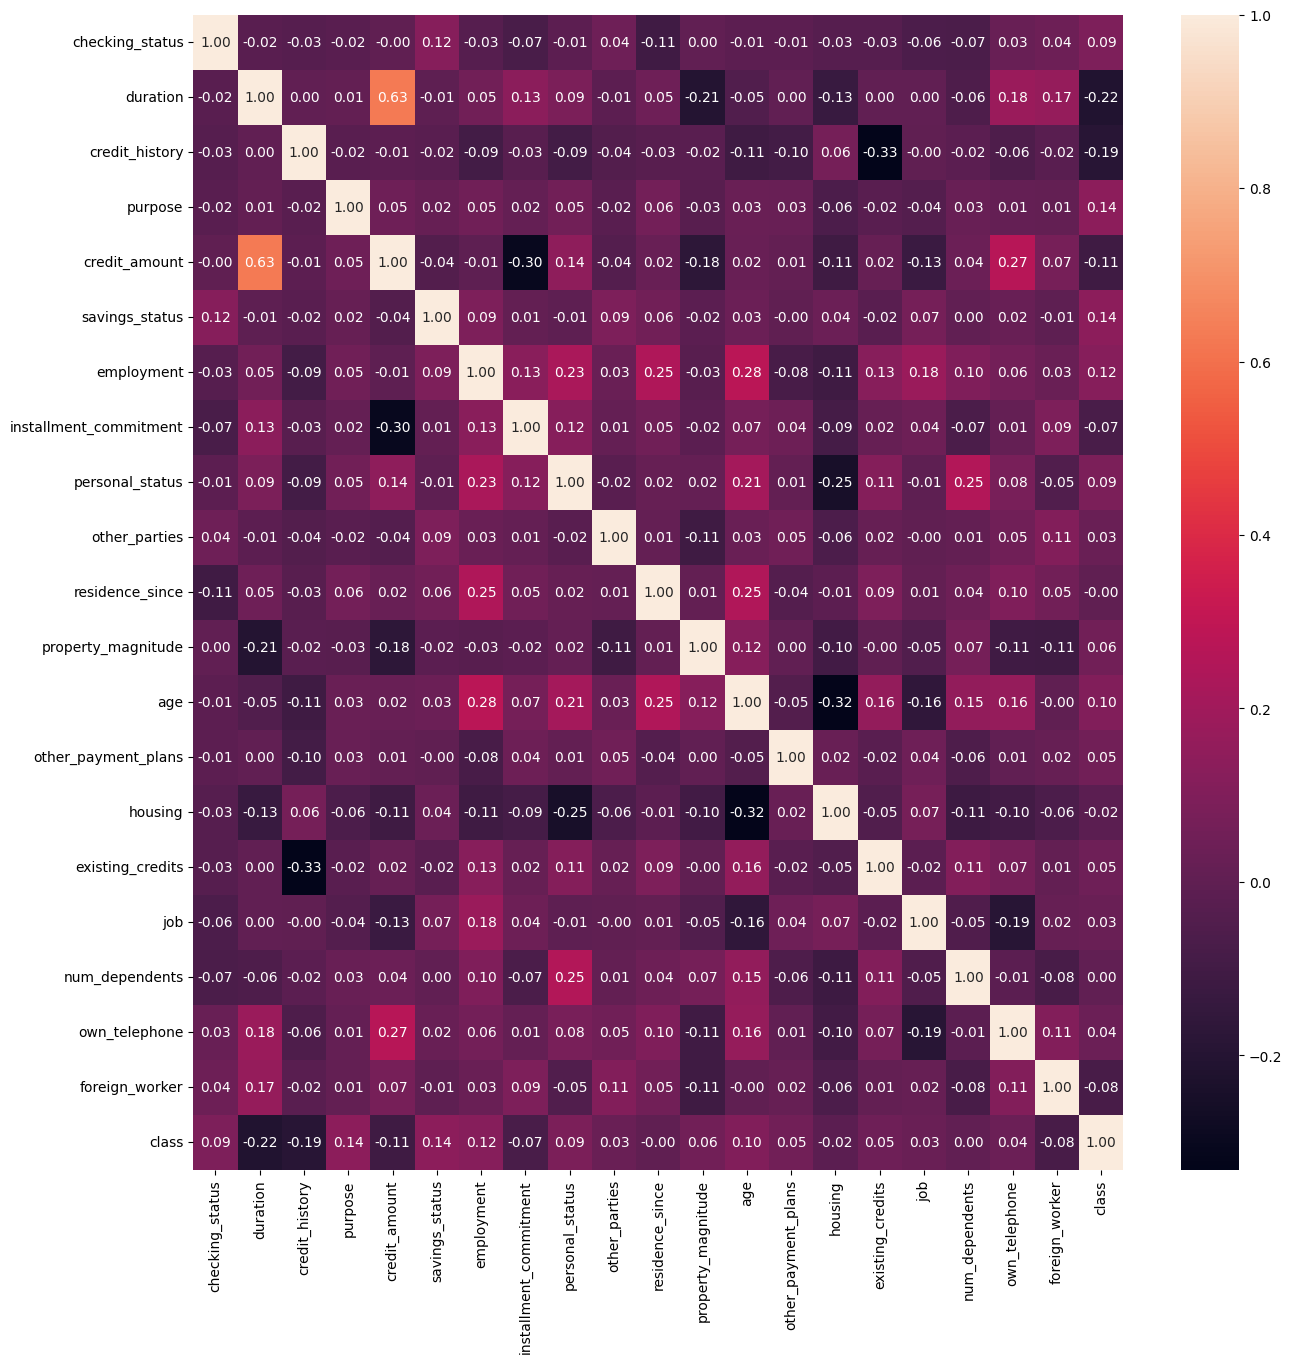

In [19]:
plt.subplots(figsize=(15,15))
sns.heatmap(data=df.corr(), annot=True, fmt=".2f")

It doesn't seem like much of the dataset is very highly correlated - 'duration' and 'credit_amount' are the highest at 0.63, but not much else even gets very close to that. Our 'class' variable (credit score) has very little highly correlated with it - 'duration', 'credit_history', and 'credit_amount' are the most negatively correlated at -0.22, -0.19, and -0.11 respectively, and 'purpose', 'savings_status', and 'employment' are the most highly correlated, at 0.14, 0.14, and 0.12 respectively. 

### Initial Conclusions from Exploratory Data Analysis and Hypothesis Testing

There aren't any individual attributes that will give us very strong insights into what class a specific instance is, but there are defenitely differences between the two classes (as seen in Hypothesis Tests 2 & 3). The classes defenitely have a lot of overlap, which means the accuracy may not end up being great, but with the amount of attributes we have, and the fact that some of them have clear differences between the classes, we may be able to achieve a higher accuracy than expected. 

<hr></hr>
<h2 style="text-align: center;">Machine Learning Analysis</h2>

We first split the data into training and testing, with 20% of the data used for testing / evaluating each model. We use will use four models: KNN, SVM, Random Forest, and MLP to classify good and bad credit risks.

In [20]:
train, test = train_test_split(df, test_size=0.2, random_state=42)
X_train = train.drop(['class'], axis=1)
y_train = train['class']
X_test = test.drop(['class'], axis=1)
y_test = test['class']

<b>K Nearest Neighbors (KNN) Training / Evaluation</b>

KNN Cross Validation Accuracy: 68.00% +/- 1.70%
KNN Accuracy on test set: 69.00%


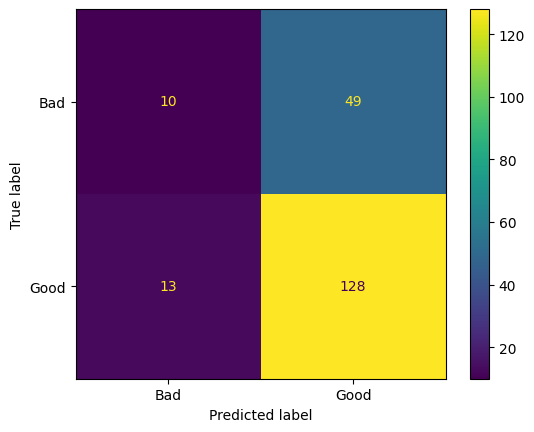

Classification Report: 
               precision    recall  f1-score   support

        Good       0.43      0.17      0.24        59
         Bad       0.72      0.91      0.81       141

    accuracy                           0.69       200
   macro avg       0.58      0.54      0.52       200
weighted avg       0.64      0.69      0.64       200



In [21]:
KNN = KNeighborsClassifier()
KNN.fit(X_train, y_train)
cv_scores = cross_val_score(KNN, X_train, y_train, cv=5)
print(f"KNN Cross Validation Accuracy: {np.mean(cv_scores)*100:.2f}% +/- {np.std(cv_scores)*100:.2f}%")
y_pred_test = KNN.predict(X_test)
print(f"KNN Accuracy on test set: {accuracy_score(y_test, y_pred_test)*100:.2f}%")
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Bad', 'Good'])
disp.plot()
plt.show()
print("Classification Report: \n", classification_report(y_test, y_pred_test, target_names=['Good', 'Bad']))

<b>Support Vector Machine (SVM) Training / Evaluation</b>

SVM Cross Validation Accuracy: 72.62% +/- 1.74%
SVM Accuracy on test set: 73.50%


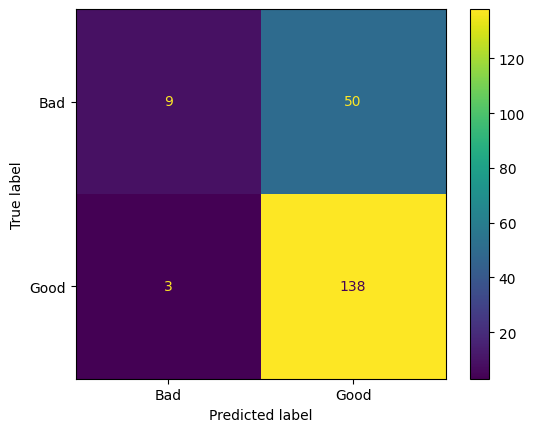

Classification Report: 
               precision    recall  f1-score   support

        Good       0.75      0.15      0.25        59
         Bad       0.73      0.98      0.84       141

    accuracy                           0.73       200
   macro avg       0.74      0.57      0.55       200
weighted avg       0.74      0.73      0.67       200



In [22]:
SVM = SVC(kernel='linear', probability=True)
SVM.fit(X_train, y_train)
cv_scores = cross_val_score(SVM, X_train, y_train, cv=5)
print(f"SVM Cross Validation Accuracy: {np.mean(cv_scores)*100:.2f}% +/- {np.std(cv_scores)*100:.2f}%")
y_pred_test = SVM.predict(X_test)
print(f"SVM Accuracy on test set: {accuracy_score(y_test, y_pred_test)*100:.2f}%")
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Bad', 'Good'])
disp.plot()
plt.show()
print("Classification Report: \n", classification_report(y_test, y_pred_test, target_names=['Good', 'Bad']))

<b>Random Forest Training / Evaluation</b>

Random Forest Cross Validation Accuracy: 75.25% +/- 1.09%
Random Forest Accuracy on test set: 79.50%


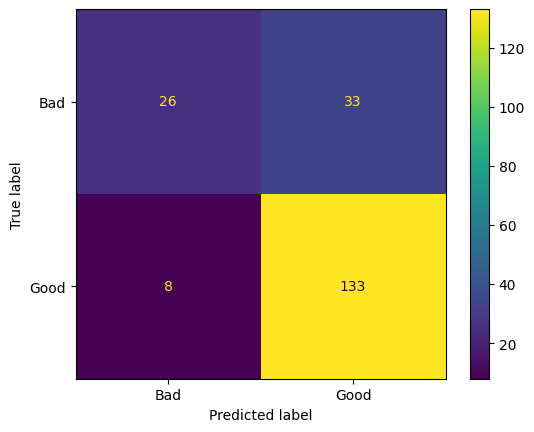

Classification Report: 
               precision    recall  f1-score   support

        Good       0.76      0.44      0.56        59
         Bad       0.80      0.94      0.87       141

    accuracy                           0.80       200
   macro avg       0.78      0.69      0.71       200
weighted avg       0.79      0.80      0.78       200



In [23]:
# Random forest classifier
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
cv_scores = cross_val_score(rfc, X_train, y_train, cv=5)
print(f"Random Forest Cross Validation Accuracy: {np.mean(cv_scores)*100:.2f}% +/- {np.std(cv_scores)*100:.2f}%")
y_pred_test = rfc.predict(X_test)
print(f"Random Forest Accuracy on test set: {accuracy_score(y_test, y_pred_test)*100:.2f}%")
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Bad', 'Good'])
disp.plot()
plt.show()
print("Classification Report: \n", classification_report(y_test, y_pred_test, target_names=['Good', 'Bad']))


<b>Multi-Layer Perceptron (MLP) Training / Evaluation</b>

100%|██████████| 500/500 [01:08<00:00,  7.33it/s]


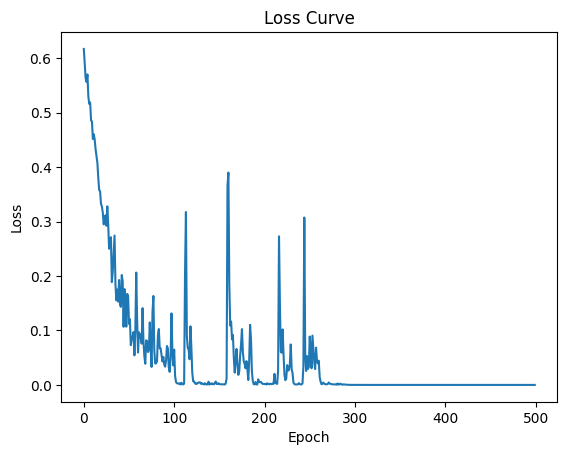

In [24]:
from tqdm import tqdm
MLP = nn.Sequential(
    nn.Linear(X_train.shape[1], 256),
    nn.ReLU(),
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.Linear(256, 64),
    nn.ReLU(),
    nn.Linear(64, 1)
)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(MLP.parameters(), lr=0.005)
epochs = 500
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MLP.to(device)
X_train_tensor = torch.tensor(X_train.to_numpy(), dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test.to_numpy(), dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.float32).to(device)

train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
losses = []

for epoch in tqdm(range(epochs)):
    MLP.train()
    train_losses = []
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = MLP(X).squeeze()
        loss = criterion(y_pred, y)
        train_losses.append(loss.item())
        loss.backward()
        optimizer.step()
    losses.append(np.mean(train_losses))

plt.plot(losses)
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


In [25]:
kfold = KFold(n_splits=5, shuffle=True)
validation_accuracies = []

for train_index, val_index in kfold.split(X_train):
    X_train_fold = torch.tensor(X_train.values[train_index], dtype=torch.float32)
    y_train_fold = torch.tensor(y_train.values[train_index], dtype=torch.float32)
    X_val_fold = torch.tensor(X_train.values[val_index], dtype=torch.float32)
    y_val_fold = torch.tensor(y_train.values[val_index], dtype=torch.float32)
    MLP_clone = nn.Sequential(
        nn.Linear(X_train_fold.shape[1], 256),
        nn.ReLU(),
        nn.Linear(256, 256),
        nn.ReLU(),
        nn.Linear(256, 256),
        nn.ReLU(),
        nn.Linear(256, 64),
        nn.ReLU(),
        nn.Linear(64, 1),
        nn.Sigmoid()
    )
    optimizer = torch.optim.Adam(MLP_clone.parameters(), lr=0.01)
    criterion = torch.nn.BCELoss()
    epochs = 100
    for epoch in range(epochs):
        MLP_clone.train()
        optimizer.zero_grad()
        y_pred_train = MLP_clone(X_train_fold)
        loss = criterion(y_pred_train.view(-1, 1), y_train_fold.view(-1, 1))
        loss.backward()
        optimizer.step()

    MLP_clone.eval()
    y_pred_val = MLP_clone(X_val_fold)
    y_pred_val = (y_pred_val > 0.5).float() 
    val_accuracy = accuracy_score(y_val_fold.cpu().numpy(), y_pred_val.cpu().detach().numpy())
    validation_accuracies.append(val_accuracy)

mean_val_accuracy = np.mean(validation_accuracies)
std_val_accuracy = np.std(validation_accuracies)

MLP Cross Validation Accuracy: 69.50% +/- 1.74%
MLP Accuracy on test set: 73.00%


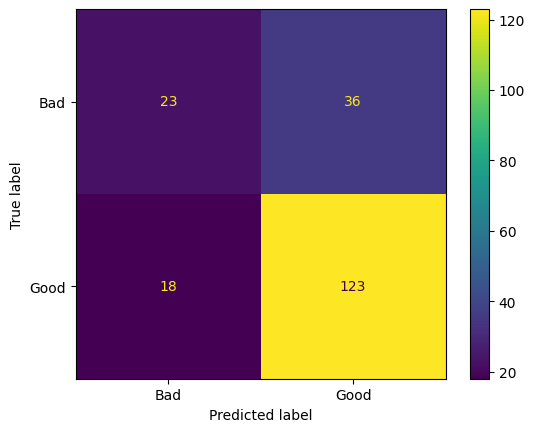

Classification Report: 
               precision    recall  f1-score   support

        Good       0.56      0.39      0.46        59
         Bad       0.77      0.87      0.82       141

    accuracy                           0.73       200
   macro avg       0.67      0.63      0.64       200
weighted avg       0.71      0.73      0.71       200



In [26]:
MLP.eval()
y_pred_test = MLP(X_test_tensor).squeeze().detach().cpu().numpy()
y_pred_test[y_pred_test >= 0.5] = 1
y_pred_test[y_pred_test < 0.5] = 0
print(f"MLP Cross Validation Accuracy: {mean_val_accuracy * 100:.2f}% +/- {std_val_accuracy * 100:.2f}%")
print(f"MLP Accuracy on test set: {accuracy_score(y_test, y_pred_test)*100:.2f}%")
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Bad', 'Good'])
disp.plot()
plt.show()
print("Classification Report: \n", classification_report(y_test, y_pred_test, target_names=['Good', 'Bad']))

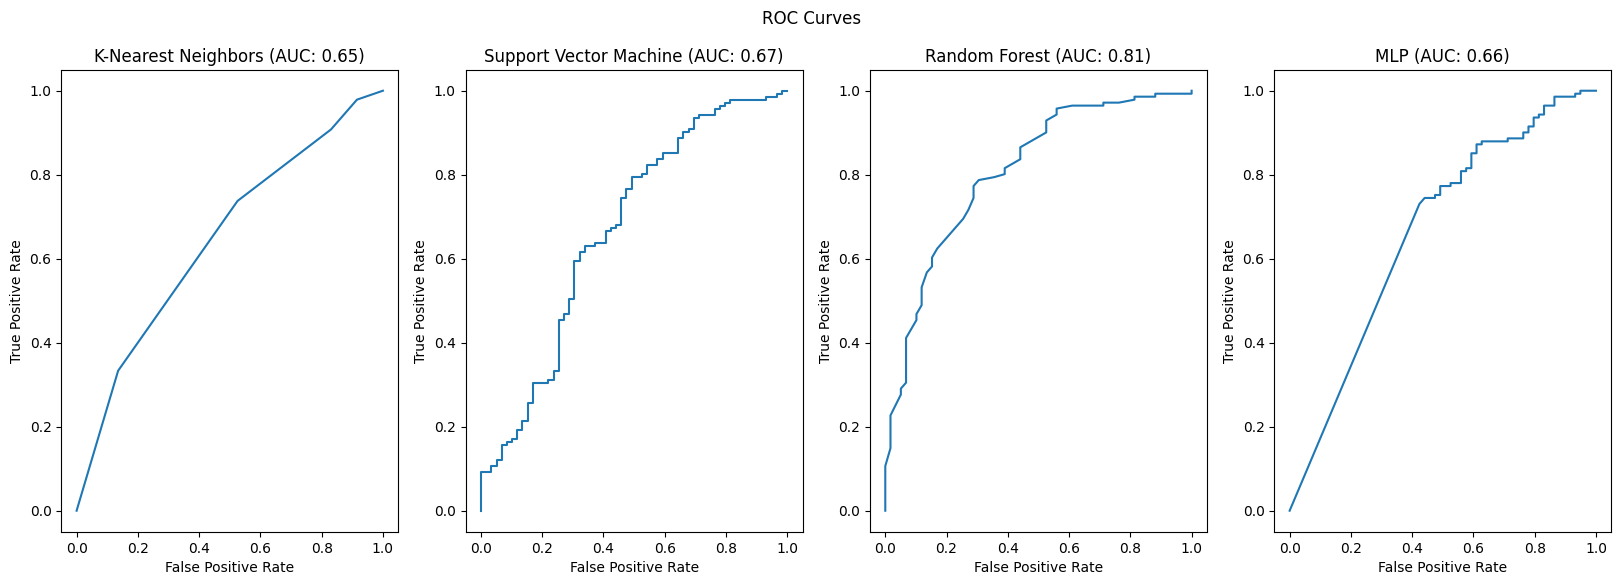

In [27]:
models = [KNN, SVM, rfc, MLP]
plt.figure(figsize=(20, 6))
plt.suptitle('ROC Curves')
model_names = ['K-Nearest Neighbors', 'Support Vector Machine', 'Random Forest', 'MLP']
for i, model in enumerate(models, 1):
    plt.subplot(1, len(models), i)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    if model == MLP: # We need to use direct model prediction for MLP as there is no predict_proba function in torch
        y_pred = torch.sigmoid(model(X_test_tensor)).cpu().detach().numpy()
    else:
        y_pred = model.predict_proba(X_test)[:, 1]

    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr)
    roc_auc = auc(fpr, tpr)
    plt.title(f"{model_names[i - 1]} (AUC: {roc_auc:.2f})")

plt.show()

From the above results, we can see that at the current stage, the best model is Random Forest, as it has the highest test accuracy of 79.5% and the highest f1-score at 0.87. Overall, the recall scores for all models were close to one, which is exactly what we want as it is better to have a false negative than a false positive in this case. This is because for classifying credit risk as we don't want to be wrong, it is better to classify someone as a bad credit risk than a good credit risk if the bank is unsure since a signing a bad credit risk can have more significant repercussions. The high f1-score is supported by a high AUC score (0.80) and ROC curve that hangs to the left as much as possible, which signifies that Random Forest is best at distinguishing between positive and negative datapoints.

<hr></hr>
<h2 style="text-align: center;">Insights and Conclusions</h2>

In [28]:
feature_importances_df = pd.DataFrame()
feature_importances_df["Feature"] = rfc.feature_names_in_
feature_importances_df["Importance"] = rfc.feature_importances_
feature_importances_df.sort_values(by="Importance", inplace=True, ascending=False)
feature_importances_df

,Feature,Importance
4,credit_amount,0.140919
12,age,0.117577
1,duration,0.097495
0,checking_status,0.080506
2,credit_history,0.068965
3,purpose,0.067391
6,employment,0.051928
7,installment_commitment,0.045988
11,property_magnitude,0.043525
5,savings_status,0.043203


Because we trained a Random Forest model, and specifically because it was the best model found, we can actually extract the feature importances across the Forest, which demonstrates how important each feature was to deciding what class to classify the instance as. So we can say that the most important indicators of your credit score are your credit amount, your age, the duration of the credit, and your checking status. 

### Final Insights

We hope that through this project, you might have learned a little more about the varying factors that go into your credit score. Something important to note is that credit score is defenitely not something you can predict easily, and takes into account many variables, potentially even more than the 20 features we had in this dataset. Our peak accuracy was only around 80%, which means that your credit score isn't just a simple relationship based on those features. Credit scores are determined based on an individual basis, and banks oftentimes like to be more reserved on giving good credit scores than bad ones, as that makes them less likely to lose money. Predicing your credit based on the variables above may be a good marker, but it's always best to go to the banks and have them assess it for you, as predicting it yourself likely won't be accurate. 

We hope that you've also gained some insights into how you would apply machine learning and data science to solve a real world problem like this - we have demonstrated everything from detailed pre-processing and data exploration, to multiple methods of analyzing the data using machine learning. This process can be applied to many problems, and the techniques demonstrated here are important for any data scientist, especially the ability to communicate your analysis through charts and explanations. 